In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

# Baseline building

In [17]:
# 28 parameters
class SmallClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # 1. Feature Extractor
        # Input: 1 -> Output: 2 channels (2D coordinates)
        # bias=False saves us 2 parameters
        self.features = nn.Sequential(
            nn.Conv1d(1, 2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(2),
            nn.ReLU(),
        )

        # 2. Aggregator
        # Finds the peak activation for coordinate X and coordinate Y
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        # 3. Classifier
        # Draws lines on the 2D plane to separate the 6 classes
        self.classifier = nn.Linear(2, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        return self.classifier(x)

In [18]:
#
# ~ 50 parameters
#

class BiggerClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # 1. Feature Extractor
        # Input: 1 -> Output: 3 channels (Just 3 features!)
        self.features = nn.Sequential(
            nn.Conv1d(1, 3, kernel_size=5, padding=2),
            nn.BatchNorm1d(3), # Crucial for convergence
            nn.ReLU(),
        )

        # 2. Global Pool
        # Collapses [Batch, 3, 1024] -> [Batch, 3, 1]
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        # 3. Classifier
        # Maps the 3 features to 6 classes
        self.classifier = nn.Linear(3, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        return self.classifier(x)

In [19]:
#
# ~ 200 parameters
#

class EvenBiggerClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            # Layer 1: Very thin feature detector
            # Input: 1 -> Output: 4 channels
            nn.Conv1d(1, 4, kernel_size=5, padding=2),
            nn.BatchNorm1d(4), # Keeps convergence fast
            nn.ReLU(),
            nn.MaxPool1d(4),

            # Layer 2: Minimal expansion
            # Input: 4 -> Output: 8 channels
            # We use a smaller kernel (3) here to save weights
            nn.Conv1d(4, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
        )

        # Global Max Pooling: "Did the feature appear?"
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        # Classifier: Maps just 8 numbers to your 6 classes
        self.classifier = nn.Linear(8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        return self.classifier(x)

# Benchmarking Baseline models

In [20]:
sys.path.append(os.path.abspath('/app/src/lib')) #import Dataloader

from dataloader import FlagDataset

In [22]:
# 1. Setup
dataset = FlagDataset("/app/data/processed/consolidated_labels.csv", target_length=512)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

Model           | Params   | Status
-------------------------------------------------------
SmallClassifier | 28       | Acc: >MAX, Loss~0: >MAX
BiggerClassifier | 48       | Acc: >MAX, Loss~0: >MAX
EvenBiggerClassifier | 206      | Acc: 272, Loss~0: 1526


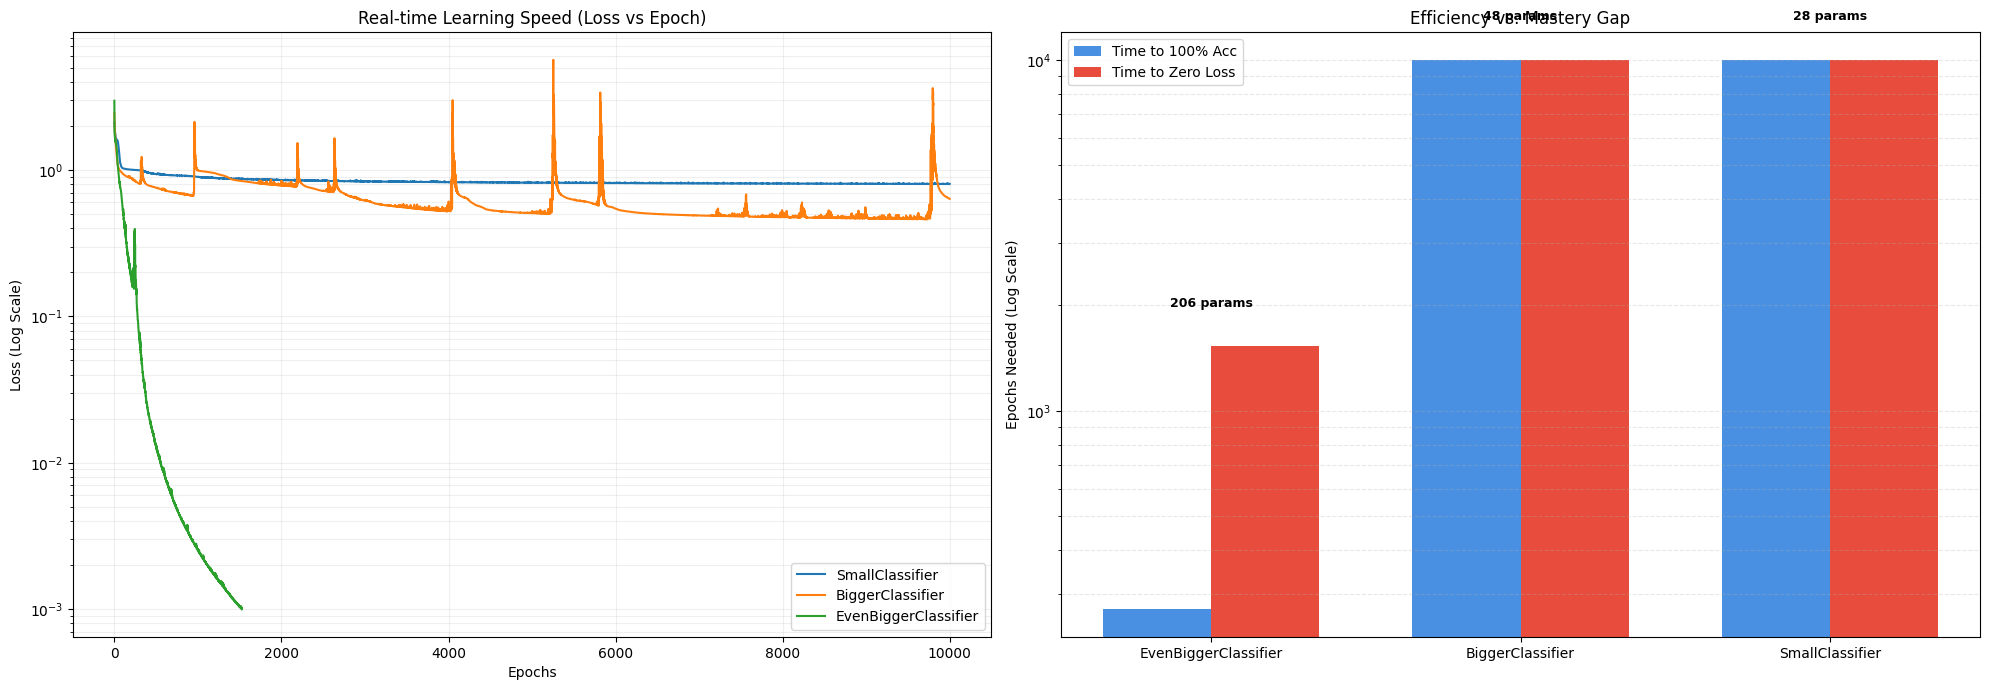


=== FINAL DATA ===
               Model  Params  Epochs (Acc=100%)  Epochs (Loss<0.001)
EvenBiggerClassifier     206                272                 1526
    BiggerClassifier      48              10000                10000
     SmallClassifier      28              10000                10000


In [25]:

# --- CONFIG ---
MAX_EPOCHS = 10000
LOSS_THRESHOLD = 0.001

#
# Fixed small batch of dataset
#
fixed_inputs, fixed_labels, fixed_indices = next(iter(dataloader))



model_candidates = [
    ("SmallClassifier", SmallClassifier),
    ("BiggerClassifier", BiggerClassifier),
    ("EvenBiggerClassifier", EvenBiggerClassifier),

]

results_data = []
loss_histories = {} # Store full history for the line plot

print(f"{'Model':<15} | {'Params':<8} | {'Status'}")
print("-" * 55)

# --- TRAINING LOOP ---
for name, model_cls in model_candidates:
    # 1. Setup
    torch.manual_seed(42)
    model = model_cls(num_classes=6)
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # 2. Tracking
    epoch_acc_100 = None
    epoch_loss_zero = None
    history = []

    model.train()

    for epoch in range(1, MAX_EPOCHS + 1):
        optimizer.zero_grad()
        outputs = model(fixed_inputs)
        loss = criterion(outputs, fixed_labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        loss_val = loss.item()
        history.append(loss_val) # Save for plotting

        preds = torch.argmax(outputs, dim=1)
        acc = (preds == fixed_labels).float().mean()

        # Milestone 1: Accuracy 100%
        if acc == 1.0 and epoch_acc_100 is None:
            epoch_acc_100 = epoch

        # Milestone 2: Loss < Threshold
        if loss_val < LOSS_THRESHOLD and epoch_loss_zero is None:
            epoch_loss_zero = epoch

        # Stop condition: Both milestones met
        if epoch_acc_100 is not None and epoch_loss_zero is not None:
            break

    # Save Data
    loss_histories[name] = history

    # Handle DNF (Did Not Finish)
    res_acc = epoch_acc_100 if epoch_acc_100 else MAX_EPOCHS
    res_loss = epoch_loss_zero if epoch_loss_zero else MAX_EPOCHS

    # Print status
    acc_str = str(epoch_acc_100) if epoch_acc_100 else ">MAX"
    loss_str = str(epoch_loss_zero) if epoch_loss_zero else ">MAX"
    print(f"{name:<15} | {param_count:<8} | Acc: {acc_str}, Loss~0: {loss_str}")

    results_data.append({
        "Model": name,
        "Params": param_count,
        "Epochs (Acc=100%)": res_acc,
        "Epochs (Loss<0.001)": res_loss
    })

# --- VISUALIZATION ---

# Prepare Data
df = pd.DataFrame(results_data)
df = df.sort_values(by="Params", ascending=False)

# Create 2 Subplots: Left = Line Plot, Right = Bar Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# --- PLOT 1: Convergence Lines ---
for name, history in loss_histories.items():
    ax1.plot(history, label=f"{name}")

ax1.set_title("Real-time Learning Speed (Loss vs Epoch)")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss (Log Scale)")
ax1.set_yscale('log') # Crucial for seeing the fast drops
ax1.legend()
ax1.grid(True, which="both", ls="-", alpha=0.2)


# --- PLOT 2: Milestone Bars ---
x = np.arange(len(df))
width = 0.35

# Bar 1: Time to Acc=100%
ax2.bar(x - width/2, df["Epochs (Acc=100%)"], width, label='Time to 100% Acc', color='#4a90e2')
# Bar 2: Time to Loss~0
ax2.bar(x + width/2, df["Epochs (Loss<0.001)"], width, label='Time to Zero Loss', color='#e74c3c')

ax2.set_title("Efficiency vs. Mastery Gap")
ax2.set_ylabel("Epochs Needed (Log Scale)")
ax2.set_xticks(x)
ax2.set_xticklabels(df["Model"])
ax2.set_yscale('log') # Log scale because Nano takes 1000s, Baseline takes 30
ax2.legend()
ax2.grid(True, which="both", axis='y', linestyle='--', alpha=0.3)

# Add param counts on top of bars
for i, row in df.reset_index().iterrows():
    y_pos = max(row["Epochs (Acc=100%)"], row["Epochs (Loss<0.001)"]) * 1.3
    ax2.text(i, y_pos, f"{row['Params']} params", ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print Table
print("\n=== FINAL DATA ===")
print(df.to_string(index=False))

Az előbbi scriptet többször futtatva, egyre nagyobb paraméterű modelleket definiáltam, amíg a modell el nem érte a 100%-os pontosságot és közel 0 loss értéket. A használt baseline modell: "EvenBiggerClassifier"

# Model building

Cél: Egy jobb modell építése a Baseline -nál

In [27]:
class FlagClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            # Layer 1: Conv -> BN -> ReLU -> Pool
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm1d(16),  # <--- The magic fix
            nn.ReLU(),
            nn.MaxPool1d(4),

            # Layer 2: Conv -> BN -> ReLU
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),  # <--- The magic fix
            nn.ReLU(),
        )

        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.classifier = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        return self.classifier(x)

Módosítások:
| Feature | FastCompactClassifier | MicroClassifier |
| :--- | :--- | :--- |
| **Layer 1 Channels** | 1 $\to$ **16** | 1 $\to$ **4** |
| **Layer 2 Channels** | 16 $\to$ **32** | 4 $\to$ **8** |
| **Layer 2 Kernel** | 5 | 3 |
| **Final Embedding** | 32 features | 8 features |
| **Approx. Params** | **~2,800** | **~200** |

Azt várjuk, hogy a modell pontosabb lesz. (Ellenkező esetben módosítok még rajta.)

- Végül nem kellett módosítani 🙂